In [2]:
# You can import *ANYTHING* you want here.
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_percentage_error # Requires sklearn 0.24 (December 2020), update with conda/pip if needed.
from sklearn.model_selection import GridSearchCV, train_test_split

import pandas as pd

# Assignment 8: Tree methods

In this assignment we'll study tree methods and their capabilities as interpolators and extrapolators, and the importance of understanding your data. We will use a dataset of energy consumption of home appliances for houses in Chievres, Belgium. The data has the following variables:

- date time year-month-day hour:minute:second
- Appliances, energy use in Wh (**Target variable**)energy_extrapolation
- lights, energy use of light fixtures in the house in Wh
- T1, Temperature in kitchen area, in Celsius
- RH_1, Humidity in kitchen area, in %
- T2, Temperature in living room area, in Celsius
- RH_2, Humidity in living room area, in %
- T3, Temperature in laundry room area
- RH_3, Humidity in laundry room area, in %
- T4, Temperature in office room, in Celsius
- RH_4, Humidity in office room, in %
- T5, Temperature in bathroom, in Celsius
- RH_5, Humidity in bathroom, in %
- T6, Temperature outside the building (north side), in Celsius
- RH_6, Humidity outside the building (north side), in %
- T7, Temperature in ironing room , in Celsius
- RH_7, Humidity in ironing room, in %
- T8, Temperature in teenager room 2, in Celsius
- RH_8, Humidity in teenager room 2, in %
- T9, Temperature in parents room, in Celsius
- RH_9, Humidity in parents room, in %
- To, Temperature outside (from Chievres weather station), in Celsius
- Pressure (from Chievres weather station), in mm Hg
- RH_out, Humidity outside (from Chievres weather station), in %
- Wind speed (from Chievres weather station), in m/s
- Visibility (from Chievres weather station), in km
- Tdewpoint (from Chievres weather station), in C degrees

You are given two datasets: energy_appliances_standard.csv and energy_appliances_extrapolation.csv. The first dataset has typical consumption patterns, while the second one has the top 10% highest consumptions and will be used to test the extrapolating capacities of our models.


## Task 1: Random Forests (35/100)

Random Forests are excellent predictors. Usually we only need to tune one parameter: the number of trees in the model. However, how many trees are enough? Follow these steps:

1. Load the training dataset (energy_appliances_standard.csv) and show the descriptive statistics of the variables. (3 pts)

2. Create a train / test partition of the data using 30% of the data for the test set and a ```random_state``` value of 20201107(2 pts).

3. Follow [this example](https://scikit-learn.org/stable/auto_examples/ensemble/plot_ensemble_oob.html) and train a [Random Forest Regressor](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html) using ```Appliances``` as the target variable. Test between 50 and 250 trees, plotting the Out-of-Bag (OOB) error after every iteration. Be patient as training can take a while. Written answer: What is the optimal number of trees for your model and why do you think this? (15 pts)

4. Train your final random forest with the number of trees you selected in part 3. Apply this model over your test set and over the extrapolating dataset (from the file ```energy_appliances_extrapolation.csv```), calculating the mean absolute percentual error for each dataset.  Show in a scatterplot the predicted value vs the real value of the target variable for both the test set and the extrapolation set (in the same plot), differentiating both by using different colors for the points. Written answer: How does the random forest model perform on predicting Appliance energy usage in the extrapolation data set? If it performs poorly, why? If it performs well, why? *Hint: look at the scatterplot*. (15 points)

In [3]:
# Data load

df=pd.read_csv("energy_appliances_standard.csv")
df.describe()


,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,...,T8,RH_8,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint
count,17735.000000,17735.000000,17735.000000,17735.000000,17735.000000,17735.000000,17735.000000,17735.000000,17735.000000,17735.000000,...,17735.000000,17735.000000,17735.000000,17735.000000,17735.000000,17735.000000,17735.000000,17735.000000,17735.000000,17735.000000
mean,68.121229,3.445729,21.688855,40.150264,20.293891,40.469997,22.230926,39.160423,20.860319,38.983631,...,22.050534,43.016242,19.505556,41.552215,7.314032,755.566425,80.249079,3.969812,38.305214,3.762879
std,30.182146,7.552424,1.604312,3.930099,2.171999,4.063088,1.969945,3.219280,2.047586,4.320711,...,1.961083,5.202160,2.010550,4.161873,5.291010,7.339842,14.768037,2.447164,11.957900,4.187098
min,10.000000,0.000000,16.790000,27.023333,16.100000,20.463333,17.200000,28.766667,15.100000,27.660000,...,16.306667,29.600000,14.890000,29.166667,-5.000000,729.366667,24.000000,0.000000,1.000000,-6.600000
25%,50.000000,0.000000,20.760000,37.260000,18.790000,37.930000,20.790000,36.826667,19.566667,35.500000,...,20.828889,39.200000,18.066667,38.530000,3.500000,751.000000,71.333333,2.000000,29.000000,0.933333
50%,60.000000,0.000000,21.600000,39.533333,19.926667,40.545000,22.100000,38.466667,20.666667,38.363333,...,22.166667,42.440000,19.390000,40.863333,6.850000,756.100000,84.333333,3.500000,40.000000,3.433333
75%,80.000000,0.000000,22.600000,42.863333,21.463333,43.326667,23.290000,41.530000,22.100000,42.066667,...,23.390000,46.590000,20.600000,44.290000,10.333333,760.950000,91.845238,5.333333,40.000000,6.550000
max,190.000000,50.000000,26.200000,59.633333,29.856667,56.026667,29.100000,49.656667,26.200000,51.000000,...,27.230000,58.780000,24.500000,53.326667,26.100000,772.283333,100.000000,14.000000,66.000000,15.500000


In [4]:
# Create train / test split

Dtrain,Dtest=train_test_split(df,test_size=0.3,random_state=20201107)

In [8]:
# Define random forest and iterate over the number of trees
Xtrain=Dtrain.drop("Appliances",axis="columns")
ytrain=Dtrain.Appliances

treenumber=np.linspace(50,250,201)
oob_error=np.zeros(len(treenumber))
randomforest=RandomForestRegressor(oob_score=True,warm_start=True)
for i in range (50,251):
    randomforest.set_params(n_estimators=i)
    randomforest.fit(Xtrain,ytrain)
    oob_error[i-50]=1-randomforest.oob_score_



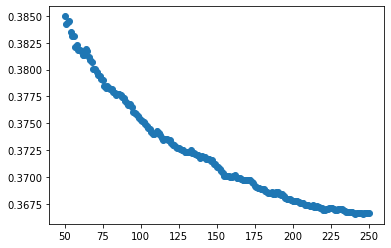

In [12]:
# Plot the OOB error per number of trees
plt.scatter(treenumber,oob_error)



**Written answer:**
The optimal number of tree is 246. As the number of trees increase from 50 to 246, the oob error decreases, because the model becomes more complex. Then the model can better fit to our training data. However, as the number of trees increases from 246 to 250, the model starts to fit the noises, so the model becomes overfitted to the training set. Therefore, the oob error also increases. 246 gives the lowest oob error, so it is the optimal number of trees.

In [14]:
# Final forest
FinalRandomForest=RandomForestRegressor(n_estimators=246)
FinalRandomForest.fit(Xtrain,ytrain)
# Calculate error over test set

Xtest=Dtest.drop("Appliances",axis="columns")
ytest=Dtest.Appliances

print("mean absolute percentual error for test set is",mean_absolute_percentage_error(ytest,FinalRandomForest.predict(Xtest)))
# Load the second dataset
extrapolation=pd.read_csv("energy_appliances_extrapolation.csv")
Xextrapolation=extrapolation.drop("Appliances",axis="columns")
yextrapolation=extrapolation.Appliances
# Calculate the error over it
print("mean absolute percentual error for extrapolating dataset is",mean_absolute_percentage_error(yextrapolation,FinalRandomForest.predict(Xextrapolation)))

mean absolute percentual error for test set is 0.1928692839047997
mean absolute percentual error for extrapolating dataset is 0.6990628263893612


In [15]:
# Print MAPE over the sets
print("mean absolute percentual error for test set is",mean_absolute_percentage_error(ytest,FinalRandomForest.predict(Xtest)))
print("mean absolute percentual error for extrapolating dataset is",mean_absolute_percentage_error(yextrapolation,FinalRandomForest.predict(Xextrapolation)))

mean absolute percentual error for test set is 0.1928692839047997
mean absolute percentual error for extrapolating dataset is 0.6990628263893612


Text(0, 0.5, 'predicted value')

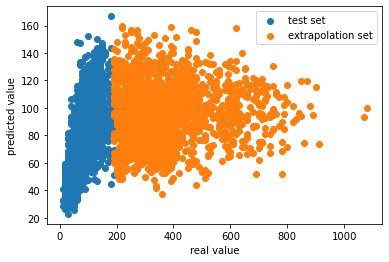

In [39]:
# Make the scatterplot
plt.scatter(ytest,FinalRandomForest.predict(Xtest))
plt.scatter(yextrapolation,FinalRandomForest.predict(Xextrapolation))
plt.legend(["test set","extrapolation set"])
plt.xlabel("real value")
plt.ylabel("predicted value")



**Written answer: **
Performance of random forest model on predicting Appliance energy usage in the extrapolation data set is poor. Extrapolation data have larger values for Appliance energy usage. Our training and test set does not have data points that have large appliance energy usage. As a result, our model that was trained on training set cannot accurately predict applicance energy usage for extrapolation set.

## Task 2: XGBoosting model (40 pts)

Now we'll repeat the process for the XGB model, using an [```XGBRegressor``` object](https://xgboost.readthedocs.io/en/latest/python/python_api.html). The XGBoosting model is much more sensitive to parameter changes though as it allows to tune many different parameters. For this example:

1. Written answer: Why do we say we want to use a small learning rate? Why do we say the number of trees to use depends on each dataset/problem? Why do we want to use a small tree depth? (6 pts)

2. Selecting a 30% validation sample over the training set, tune your parameters using crossvalidation. Use the following ranges:
 - Learning rate: [0.01, 0.1, 0.2].
 - max_depth: 3 to 7.
 - Number of trees: [350, 400, 450, 500]

Leave the other parameters at the values we identified in the lab (except for the objective parameter and those related to classification problems) and use a seed of 20201107. Report the optimal values of your parameters. (20 pts)

3. Repeat part 4 of the previous task, but now for your XGB model trained over the optimal parameter combination and the complete training dataset. Plot the variable importance. Written answer: What are the most important variables? Can the XGB model extrapolate? How does it compare to a random forest? (14 pts)

**Written answer part 1 (2 pts each):**
We don't want the learning rate to be large, because using a large learning rate means that gradient descent would make larger steps during training. Then we could miss global minima and reach a suboptimal set of parameters after gradient descent. Therefore, we want the learning rate to be small.
Increasing the number of trees can increase the accuracy of the model. However, a large number of trees might not improve performance by a lot. Then you don't want to use this large number of trees, because you are wasting computational power. Therefore, the number of trees depends on the problem. If the problem needs model's prediction to be very accurate, we might need a larger number of trees. However, if the model does not neeed very high accuracy, we may use a smaller number of trees.
Tree with small depth has low variance and high bias. Boosting applies to the weak learner(tree with small depth), so weak learner's bias is reduced. If we use a large tree depth, the model will have high variance, and boosting cannot reduce the variance. Therefore, we want to use small tree depth.

In [40]:
# Define the XGB model
XGB=XGBRegressor(max_depth=3,                 # Depth of each tree
                learning_rate=0.1,            # How much to shrink error in each subsequent training. Trade-off with no. estimators.
                n_estimators=100,             # How many trees to use, the more the better, but decrease learning rate if many used.
                verbosity=1,                  # If to show more errors or not.
                booster='gbtree',             # What to boost. Trees in this case.
                n_jobs=2,                     # Parallel jobs to run. Set your processor number.
                gamma=0.001,                  # Minimum loss reduction required to make a further partition on a leaf node of the tree. (Controls growth!)
                subsample=1,                  # Subsample ratio. Can set lower
                colsample_bytree=1,           # Subsample ratio of columns when constructing each tree.
                colsample_bylevel=1,          # Subsample ratio of columns when constructing each level. 0.33 is similar to random forest.
                colsample_bynode=1,           # Subsample ratio of columns when constructing each split.
                reg_alpha=1,                  # Regularizer for first fit. alpha = 1, lambda = 0 is LASSO.
                reg_lambda=0,                 # Regularizer for first fit.
                scale_pos_weight=1,           # Balancing of positive and negative weights.
                base_score=0.5,               # Global bias. Set to average of the target rate.
                random_state=20201107,        # Seed
                missing=None)                # How ar)


In [41]:
# Define the parameter grid.
param_grid = dict({'n_estimators': [350,400,450,500],
                   'max_depth': [3,4,5,6,7],
                 'learning_rate' : [0.01,0.1,0.2]
                  })

In [42]:
# Create reduced validation set.
val_train = Dtrain.sample(frac = 0.3,               # The fraction to extract
                          random_state = 20201107    # The seed.
                                       )
Xval_train=val_train.drop("Appliances",axis="columns")
yval_train=val_train.Appliances

In [46]:
# Train grid search. This takes a while! Go grab a coffee.
GridXGB = GridSearchCV(XGB,        # Original XGB. 
                       param_grid,          # Parameter grid
                       cv = 3,              # Number of cross-validation folds.  
                       n_jobs = -1,         # Parallel jobs. -1 is "all you have"
                       refit = False,       # If refit at the end with the best. We'll do it manually.
                       verbose = 1          # If to show what it is doing.
                      )
GridXGB.fit(Xval_train,yval_train)

Fitting 3 folds for each of 60 candidates, totalling 180 fits


GridSearchCV(cv=3,
             estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                    colsample_bylevel=1, colsample_bynode=1,
                                    colsample_bytree=1, gamma=0.001,
                                    gpu_id=None, importance_type='gain',
                                    interaction_constraints=None,
                                    learning_rate=0.1, max_delta_step=None,
                                    max_depth=3, min_child_weight=None,
                                    missing=None, monotone_constraints=None,
                                    n_estimators=100, n_jobs=2,
                                    num_parallel_tree=None,
                                    random_state=20201107, reg_alpha=1,
                                    reg_lambda=0, scale_pos_weight=1,
                                    subsample=1, tree_method=None,
                                    validate_parameters=None, verbos

In [47]:
# Show best params
print(GridXGB.best_params_)

{'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 350}


In [48]:
# Train final XGB with optimal parameters
optimalXGB=XGBRegressor(max_depth=GridXGB.best_params_.get('max_depth'), # Depth of each tree
                learning_rate=GridXGB.best_params_.get('learning_rate'), # How much to shrink error in each subsequent training. Trade-off with no. estimators.
                n_estimators=GridXGB.best_params_.get('n_estimators'), # How many trees to use, the more the better, but decrease learning
                verbosity=1,                  # If to show more errors or not.
                booster='gbtree',             # What to boost. Trees in this case.
                n_jobs=2,                     # Parallel jobs to run. Set your processor number.
                gamma=0.001,                  # Minimum loss reduction required to make a further partition on a leaf node of the tree. (Controls growth!)
                subsample=1,                  # Subsample ratio. Can set lower
                colsample_bytree=1,           # Subsample ratio of columns when constructing each tree.
                colsample_bylevel=1,          # Subsample ratio of columns when constructing each level. 0.33 is similar to random forest.
                colsample_bynode=1,           # Subsample ratio of columns when constructing each split.
                reg_alpha=1,                  # Regularizer for first fit. alpha = 1, lambda = 0 is LASSO.
                reg_lambda=0,                 # Regularizer for first fit.
                scale_pos_weight=1,           # Balancing of positive and negative weights.
                base_score=0.5,               # Global bias. Set to average of the target rate.
                random_state=20201107,        # Seed
                missing=None)                # How ar)

optimalXGB.fit(Xtrain,ytrain)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0.001, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.1, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=None, monotone_constraints='()',
             n_estimators=350, n_jobs=2, num_parallel_tree=1,
             random_state=20201107, reg_alpha=1, reg_lambda=0,
             scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=1)

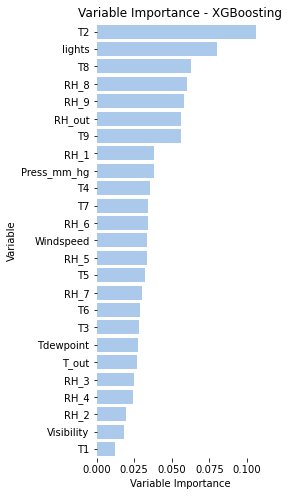

In [69]:
# Variable importance
importances =optimalXGB.feature_importances_
indices = np.argsort(importances)[::-1] 

f, ax = plt.subplots(figsize=(3, 8))
plt.title("Variable Importance - XGBoosting")
sns.set_color_codes("pastel")
sns.barplot(y=[Xtrain.columns[i] for i in indices], x=importances[indices], 
            label="Total", color="b")
ax.set(ylabel="Variable",
       xlabel="Variable Importance")
sns.despine(left=True, bottom=True)

**Written answer:**
The most imporant variables are T2 and lights. 

mean absolute percentual error for test set is 0.20466739662209935
mean absolute percentual error for extrapolating dataset is 0.6921372902534558


Text(0, 0.5, 'predicted value')

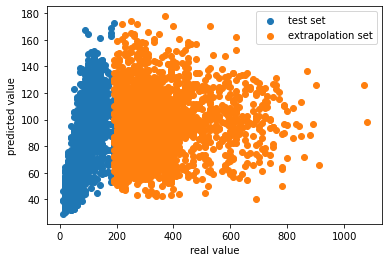

In [52]:
# Make scatterplot
# Print MAPE over the sets
print("mean absolute percentual error for test set is",mean_absolute_percentage_error(ytest,optimalXGB.predict(Xtest)))
print("mean absolute percentual error for extrapolating dataset is",mean_absolute_percentage_error(yextrapolation,optimalXGB.predict(Xextrapolation)))

plt.scatter(ytest,optimalXGB.predict(Xtest))
plt.scatter(yextrapolation,optimalXGB.predict(Xextrapolation))
plt.legend(["test set","extrapolation set"])
plt.xlabel("real value")
plt.ylabel("predicted value")

**Written answer: **
XGB model stilll cannot extrapolate. In comparison to random forest, the error for test set is larger, and the error for extrapolating set is smaller.

## Task 3: Combined model (25 pts)

Now we will finally train a model on the combined data, by joining the extrapolation and the original dataset, and study the performance over the original test set, the new test set and the combined result. For this we will only use the Random Forest model. Use a seed of 20201107 for all functions that accept one.

1. Create a train / test split set over the extrapolation data, leaving approximately 30% of the data for testing purposes. Combine this train test with the original train set (let's call this the combined train set). (5 pts)
2. Train a Random Forest model over the **combined** train data. Discuss how many trees you used and why. (15 pts)
3. Plot the variable importance and compare it versus the XGB in task 1. Now that you more data, does the importance change? (5 pts)
3. Report the test set performance of your new model over the original test set, the test set you took over the extrapolation dataset and the combined test set. Plot the scatterplot of the both datasets as before in the same plot, differentiating the dataset by using colours. (10 pts)

Written answer: What happens now? What can you say about the new model?

In [83]:
# Create the new train and test set.
trainE,testE=train_test_split(extrapolation,test_size=0.3,random_state=20201107)
newTrain=pd.concat([Dtrain,trainE])
newTest=pd.concat([Dtest,testE])


In [84]:
# Obtain the new random forest (tune the trees)
newXtrain=newTrain.drop("Appliances",axis="columns")
newytrain=newTrain.Appliances

treenumber=np.linspace(50,250,201)
oob_error=np.zeros(len(treenumber))
randomforest=RandomForestRegressor(oob_score=True,warm_start=True,random_state=20201107)
for i in range (50,251):
    randomforest.set_params(n_estimators=i)
    randomforest.fit(newXtrain,newytrain)
    oob_error[i-50]=1-randomforest.oob_score_

print("the number of trees that gives the lowest oob error is",treenumber[np.argmin(oob_error)])

the number of trees that gives the lowest oob error is 220.0


In [85]:
FinalRandomForest=RandomForestRegressor(n_estimators=220,random_state=20201107)
FinalRandomForest.fit(newXtrain,newytrain)

RandomForestRegressor(n_estimators=220, random_state=20201107)

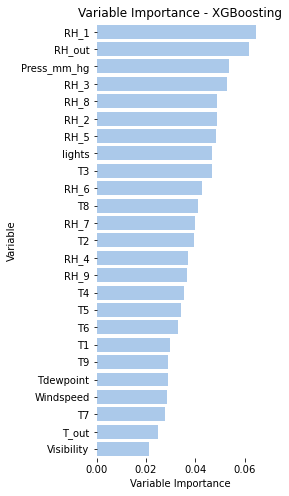

In [86]:
# Variable importance
importances =FinalRandomForest.feature_importances_
indices = np.argsort(importances)[::-1] 

f, ax = plt.subplots(figsize=(3, 8))
plt.title("Variable Importance - XGBoosting")
sns.set_color_codes("pastel")
sns.barplot(y=[newXtrain.columns[i] for i in indices], x=importances[indices], 
            label="Total", color="b")
ax.set(ylabel="Variable",
       xlabel="Variable Importance")
sns.despine(left=True, bottom=True)

**Written answer: **
I use 220 trees because it gives the lowest oob error. After having more data the importance changes. For XGBoosting, the highest variable importance is 0.1. Now the highest variable importance is about 0.06. Furthermore, for XGBoosting, many variables' importances are significantly higher than other variables. However, the variables' importances of our random forest is relatively similar. 

In [87]:
# Print MAPE over the test sets
newXtest=newTest.drop("Appliances",axis="columns")
newytest=newTest.Appliances
print("mean absolute percentual error for test set is",mean_absolute_percentage_error(ytest,FinalRandomForest.predict(Xtest)))
print("mean absolute percentual error for extrapolating dataset is",mean_absolute_percentage_error(yextrapolation,FinalRandomForest.predict(Xextrapolation)))
print("mean absolute percentual error for combined test set is",mean_absolute_percentage_error(newytest,FinalRandomForest.predict(newXtest)))

mean absolute percentual error for test set is 0.34332202320531563
mean absolute percentual error for extrapolating dataset is 0.20083893677137468
mean absolute percentual error for combined test set is 0.34443433818143654


Text(0, 0.5, 'predicted value')

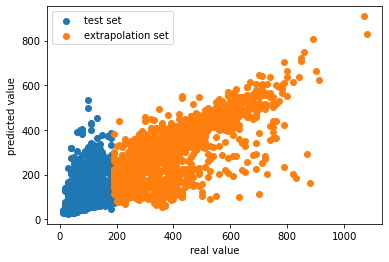

In [88]:
# Scatterplot
plt.scatter(ytest,FinalRandomForest.predict(Xtest))
plt.scatter(yextrapolation,FinalRandomForest.predict(Xextrapolation))
plt.legend(["test set","extrapolation set"])
plt.xlabel("real value")
plt.ylabel("predicted value")

**Written answer:**
Now the model can extrapolate. The MAPE of extrapolating dataset becomes much lower in comaprison to the previous two models. From the scatter plot, we can also tell that the performance on extrapolating data has improved. As the real value becomes larger, the predicted value also becomes larger. However, the error for test set is increased, because the model needs to fit both training(Appliance energy usage is small) and extrapolating dataset(appliance energy usage is quite high). Then the model becomes less accurate when it predicts appliance energy usage for the test data, which are low in appliance energy usage.